In [1]:
# Data-driven Newsvendor with Pricing
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Initalization
a = 0 #y-intercept or market size
b = 0 #coefficient of price
p = [] #price sampling
D = [] #demand sampling
u = [] #estimation error term sampling
sigma = 0 #std of estimation error terms sampling


In [3]:
#Parameters for example illustration
n = 200 #sample size
cv = 0.3 #coefficient of variance
c = 0.5 #procurement cost per unit
alpha = 0.9 #non-stockout probability

#Sampling range
lbp = 1 #lower bound of price
ubp = 1.5 #upper bound of price
lba = 1500 #lb of a
uba = 2000 #up of a
lbb = 500 #lb of b
ubb = 1000 #ub of b

# IMPLEMENTATION

We can divide the main problem into two subproblems as follows:  
1) to learn the relationship between demand/ ordering quantity and price   
2) to find optimal quantity and price   


## DEMAND/ ORDERING QUANTITY ESTIMATION (BEUTEL 2012)

**Reference:** Beutel, A. L., & Minner, S. (2012). *Safety stock planning under causal demand forecasting*. International Journal of Production Economics, 140(2), 637-645.

### Function to generate sampling of demand and price:
Demand is presented here as a function of price p: D(p) = a - b\*p + u.  
The true demand function is built by randomly choose a, b, p and D with some assumptions. In more detail:
- market size a ~ U(1500, 2000)
- slope b ~ U(500, 1000)
- uniformly chosen sample of price p (with size = sampleSize) in range [1, 1.5] 
- D equals to the sum of prediction value plus estimation error u ~ N(0, sigma). Sigma is chosen so that the coefficient of variation at mean price p equals coefVar.

It should be noticed that here we will focus on the case that demand is relatively elastic with price. The reason is that in case of relatively price elasticity, demand responds weakly with the changes of price. Therefore, the vendor has the incentive to increase price as much as possible while only facing a little decrease in demand quantity. Combining with a ratio between overage and underage cost that is low enough (co < cu), it may lead to an ordering quantity function increasing with price increase and an unbound problem in price-setting newsvendor problem. Therefore, in the sampling generation function, we will reject the sample with relatively low price elasticity (<1) by checking the arc elasticity over the defined price range from OLS linear regression demand function.


In [4]:
# Demand - Price generation
def samplingDemand(sampleSize, coefVar):
    
    global a, b, p, D, u, sigma
    a = 0; b = 0; p = []; D = []; u = []; sigma = 0;
    
    lowElasticity = True
    while lowElasticity:
        a = np.random.uniform(low = lba, high = uba)
        b = np.random.uniform(low = lbb, high = ubb)
        p = np.random.uniform(size = [sampleSize, 1])*(ubp - lbp) + lbp # uniformly chosen in price range [1, 1.5]

        meanP = np.mean(p)
        sigma = (a - b*meanP)*coefVar
        u = np.zeros(shape = (sampleSize,))
        D = np.repeat(-1, repeats = sampleSize)
        for i in range(sampleSize):
            while D[i] < 0:
                u[i] = np.random.normal(loc = 0, scale = sigma)
                D[i] = a - b*p[i] + u[i]
 

        #check Arc price elasticity
        # OLS Linear regression for comparison
        reg = linear_model.LinearRegression().fit(p, D)
        coef2 = reg.coef_
        coef1 = reg.intercept_
        Q1 = coef1 + coef2*lbp
        Q2 = coef1 + coef2*ubp
        arcElasticity = ((lbp + ubp) / (Q1 + Q2)) * ((Q2 - Q1) / (ubp - lbp))
        if abs(arcElasticity) >= 1: lowElasticity = False
    
    return coef1, coef2

Sampling example:

Text(0.5, 1.0, 'Demand sampling')

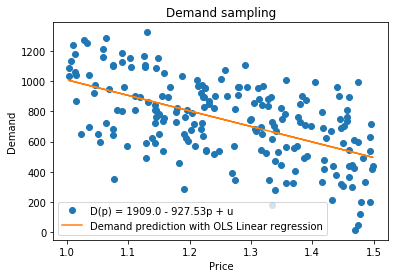

In [5]:
coef1, coef2 = samplingDemand(sampleSize = n, coefVar = cv)
plt.plot(p,D, 'o', label = 'D(p) = ' + str(round(a,0)) + ' - ' + str(round(b,2)) + 'p + u')
plt.plot(p, coef1 + coef2*p, label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.legend()
plt.title('Demand sampling')

### Optimization model to find the ordering quantity as a function of price
Here we use the approach presented in Beutel (2012) that integrates demand estimation and ordering optimization in a single model (instead of sequential steps) to learn about the relationship between ordering quantity and price. The main idea is to predict the ordering quantity by exploring historical data of demand-price with consideration of the overage and underage costs during estimating (i.e. different weights applied to the positive/negative errors in regression).  
  
There is a slight difference in two models below to the base models in Beutel (2012). In her models, Beutel assumes fixed holding cost and penalty cost, representing the overage and underage cost respectively. In other words, these costs are **independent with selling price**. However, here we will define the overage and underage cost as in the traditional newsvendor model, i.e.:     
- overage cost (co) = procurement cost (c)
- underage cost (cu) = selling price - procurement cost (p-c)

Therefore, the underage cost and so the critical fractile **depends on the selling price**. This modification is to match with the model in the second step and is more logical especially when considering the context of price-setting newsvendor, since it causes the trade-off characteristic in price decision. For example, increasing price affects the total cost (expected profit) in both positive way by decreasing underage cost (increasing revenue) per unit and negative way by decreasing demand.


Two following models assume ordering quantity is a linear function of the price: *q = beta0 + beta1 * p*. The decision variables in these models are the coefficients beta0 and beta1, as well as the waste (overage) and shortage (underage) for each demand observation. The objective function is considered as a cost minimization objective or with a service level constraint in each model.

#### The cost model

In [6]:
# Cost model
def costModel(sampleSize, procurementCost):
    
    baseCostModel = gp.Model("Base Cost model")

    #### Variables
    betaC0 = baseCostModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ a
    betaC1 = baseCostModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ b

    waste = {} # = q - D (overage)
    shortage = {} # = D - q (underage)
    sales = {} # = min(D, q)
    for i in range(sampleSize):
        #overage cost per unit = c(co)
        waste[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = procurementCost) 
        #underage cost per unit = p-c (cu)
        shortage[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = p[i] - procurementCost)

        sales[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS)

    #### Constraints
    for i in range(sampleSize):
        baseCostModel.addConstr(shortage[i] == D[i] - sales[i])
        baseCostModel.addConstr(waste[i] >= betaC0 + betaC1 * p[i] - D[i])
        baseCostModel.addConstr(sales[i] <= D[i])
        baseCostModel.addConstr(sales[i] <= betaC0 + betaC1 * p[i])
        
    baseCostModel.Params.OutputFlag = 0
    baseCostModel.optimize()
    obj = baseCostModel.objVal; beta0 = betaC0.x; beta1 = betaC1.x;
    baseCostModel.dispose()
    
    return obj, beta0, beta1

Example of ordering quantity function with Cost model

Using license file C:\Users\hadao\gurobi.lic
Academic license - for non-commercial use only
Objective: 21316.996052831353
Estimation of a: 1870.1263400661758
Estimation of b: -833.7790939455431

Ordering quantity - price function: D =  1870.0 + -833.78 * p


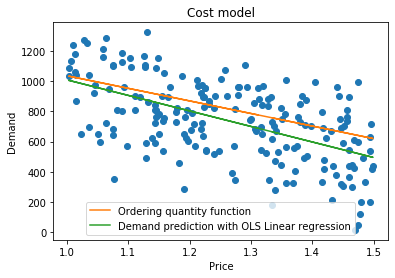

In [7]:
objC, betaC0, betaC1 = costModel(sampleSize = n, procurementCost = c)
print("Objective:",objC)
print('Estimation of a:', betaC0)
print('Estimation of b:', betaC1)

print('\nOrdering quantity - price function: D = ', round(betaC0,0),'+', round(betaC1,2),'* p')


#Plot
plt.plot(p,D,'o')
plt.plot(p, betaC0 + betaC1*p, label='Ordering quantity function')
plt.plot(p, coef1 + coef2*p, label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Cost model')
plt.show()

#### The service level model

In [8]:
# Service level model
def SLModel(sampleSize, procurementCost, nonStockOut):
    
    baseSLModel = gp.Model("Base Service level model")

    #### Variables
    betaSL0 = baseSLModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ a
    betaSL1 = baseSLModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ b

    waste = {}
    sales = {}
    unfulfilled = {} # binary variable = 1 if D > q (underage, unfulfilled demand existing), = 0 otherwise
    for i in range(sampleSize):
        waste[i] = baseSLModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = procurementCost)   
        sales[i] = baseSLModel.addVar(lb = 0, vtype = GRB.CONTINUOUS)
        unfulfilled[i] = baseSLModel.addVar(vtype = GRB.BINARY)

    #### Constraints
    for i in range(sampleSize):
        baseSLModel.addConstr(waste[i] >= betaSL0 + betaSL1 * p[i] - D[i])
        baseSLModel.addConstr(sales[i] <= D[i])
        baseSLModel.addConstr(sales[i] <= betaSL0 + betaSL1 * p[i])

        #if D < q then unfulfilled must equal to 1
        baseSLModel.addConstr(D[i] - unfulfilled[i]*np.max(D) <= betaSL0 + betaSL1 * p[i])

    #non-stockout (alpha level)    
    baseSLModel.addConstr(sum(unfulfilled[i] for i in range(sampleSize)) <= sampleSize*(1-nonStockOut)) 

    #fillrate (beta level)
    #baseSLModel.addConstr( sum(sales[i] for i in range(sampleSize)) >= fillRate * sum(D[i] for i in range(sampleSize)) )

    baseSLModel.Params.OutputFlag = 0
    baseSLModel.optimize()
    obj = baseSLModel.objVal; beta0 = betaSL0.x; beta1 = betaSL1.x;
    baseSLModel.dispose()
    
    return obj, beta0, beta1

Example of ordering quantity function with Service level model (alpha level)

Objective: 25851.408900537524
Estimation of a: 2454.5882325387847
Estimation of b: -1161.379976876837

Ordering quantity - price function: D =  2455.0 + -1161.38 * p


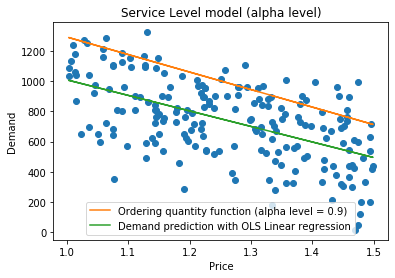

In [9]:
objSL, betaSL0, betaSL1 = SLModel(sampleSize = n, procurementCost = c, nonStockOut = alpha)
print("Objective:",objSL)
print('Estimation of a:', betaSL0)
print('Estimation of b:', betaSL1)

print('\nOrdering quantity - price function: D = ', round(betaSL0,0),'+', round(betaSL1,2),'* p')


# OLS Linear regression for comparison
reg = linear_model.LinearRegression().fit(p, D)
coef2 = reg.coef_
coef1 = reg.intercept_

#Plot
plt.plot(p,D,'o')
plt.plot(p, betaSL0 + betaSL1*p, label='Ordering quantity function (alpha level = ' +str(alpha)+')' )
plt.plot(p, coef1 + coef2*p, label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Service Level model (alpha level)')
plt.show()

## PRICE AND QUANTITY-SETTING NEWSVENDOR

**Reference:**   
Kyparisis, G.J. & Koulamas, C. (2018). *The price-setting newsvendor problem with nonnegative linear additive demand.* European Journal of Operational Research, 269(2), 695-698.   
DeYong, G. D. (2020). *The price-setting newsvendor: review and extensions.* International Journal of Production Research, 58(6), 1776-1804.

 ### Basic approach

From the previous model, we obtain the ordering quantity function of price: *q = beta0 + beta1 * p*. It means that at a certain selling price p, we can calculate a corresponding ordering quantity q, which also represents the estimated demand level at that selling price. So if the relationship between demand and price is captured completely, the expected profit is:  
$\Pi(p)  = p*q(p) - c*q(p) = beta1*p^2 + (beta0 - beta1*c)*p - beta0*c$  
By taking the first-order derivative, we can find the optimal price p* as $\frac{1}{2\beta_{1}}(-\beta_{0}+\beta_{1}*c) $   (1)  and so, the optimal ordering quantity q*.   

Below is the optimization model of this approach (hereinafter called as "Basic approach"). The optimal price from this model is similar to the one calculated from equation (1).

To make the problem logical, the lower bound of price is procurement cost per unit (p >= c) and the upper bound is -beta0/beta1 so that the expected demand is non-negative.

In [10]:
#Price-setting 
def NV_Price(procurementCost, beta0, beta1):
    pricingNV = gp.Model("Pricing NV model")

    #### Variables
    price = pricingNV.addVar(lb = procurementCost, ub = -beta0/beta1, vtype = GRB.CONTINUOUS)
    quantity = pricingNV.addVar()

    pricingNV.addConstr(quantity == beta0 + beta1*price)

    pricingNV.setObjective( price * quantity - procurementCost*quantity) #maximize expected profit
    pricingNV.modelSense = 0 #maximization

    pricingNV.Params.OutputFlag = 0
    pricingNV.Params.NonConvex = 2 #enable Quadratic Optimization mode of Gurobi
    pricingNV.optimize()
    
    return pricingNV.objVal, price.x, quantity.x

Example with results from Cost model:

In [11]:
objVal, price, quantity = NV_Price(procurementCost = c, beta0 = betaC0, beta1 = betaC1)

print('\n\n')
print('Optimal price from LP model:', price)
print('Optimal price from equation (1):', 0.5*(-betaC0+betaC1*c)/betaC1)




Optimal price from LP model: 1.371475912292615
Optimal price from equation (1): 1.371475912292615


### Data-driven approach

However, another approach is proposed here to make the solution more data-driven and robust. Using error terms obtained from historical data, we can generate the distribution of estimated demand at a certain price and then solve a data-driven quantity-setting newsvendor problem with this given price. In detail, demands at certain price p have the form of d(p) = beta0 + beta1 * p + u, with E[d(p)] = beta0 + beta1 * p, which is the estimated demand level from the previous model. u are error terms of all observations, which are independent with prices according to previously-mentioned assumptions.


In [12]:
#Newsvendor with Price-setting
def DDNV_Price(sampleSize, procurementCost, beta0, beta1):

    M = beta0*2
    
    pricingNV = gp.Model("Pricing NV model")

    #### Variables
     #same price range to avoid extrapolation ?
    price = pricingNV.addVar(lb = procurementCost, ub = -beta0/beta1, vtype = GRB.CONTINUOUS)
    quantity = pricingNV.addVar()

    sales = {}
    z = {} #binary variable = 1 if D = a - bp + u > 0, =0 otherwise ==> to ensure demand not negative: D = max(0, a-bp+u)

    for t in range(sampleSize):
        sales[t] = pricingNV.addVar()
        z[t] = pricingNV.addVar(vtype = GRB.BINARY)

    for t in range(sampleSize):
        pricingNV.addConstr(M*z[t] >= beta0 + beta1*price + u[t] ) #if a-bp+u > 0, z must equal to 1
        pricingNV.addConstr(sales[t] <= 0 + M*z[t] )
        pricingNV.addConstr(sales[t] <= beta0 + beta1*price + u[t] + M*(1-z[t]) )
        pricingNV.addConstr(sales[t] <= quantity)

    pricingNV.setObjective( price * sum(sales[t] for t in range(sampleSize)) / sampleSize - procurementCost*quantity) #maximize expected profit
    pricingNV.modelSense = 0 #maximization
    
    pricingNV.Params.OutputFlag = 0

    pricingNV.Params.NonConvex = 2 #enable Quadratic Optimization mode of Gurobi
    pricingNV.optimize()

    
    return pricingNV.objVal, price.x, quantity.x

Example run with results from Cost model

In [13]:
objValDD, priceDD, quantityDD = DDNV_Price(sampleSize = n, procurementCost = c, beta0 = betaC0, beta1 = betaC1)

print("Objective: ", objValDD)
print('Optimal price:', priceDD)
print('Optima ordering quantity:', quantityDD)

Objective:  522.2095949031229
Optimal price: 1.3453257400250487
Optima ordering quantity: 841.3100392772712


In [14]:
# method to combine two steps

In [15]:
def DDNV_main(sampleSize, procurementCost, estimationModel = 'cost', nonStockOut = None):

    if estimationModel == 'service' and nonStockOut is not None:
        (estObjVal, estBeta0, estBeta1) = SLModel(sampleSize, procurementCost)
    else:                
        (estObjVal, estBeta0, estBeta1) = costModel(sampleSize, procurementCost)
    print('\nOrdering quantity parameters:', estBeta0, estBeta1)

    (optV, optP, optQ) = NV_Price(procurementCost, estBeta0, estBeta1)
    print('Basic approach', optV, optP, optQ)

    (optVDD, optPDD, optQDD) = DDNV_Price(sampleSize, procurementCost, estBeta0, estBeta1)
    print('Data-driven approach', optVDD, optPDD, optQDD,'\n')

        
    return optV, optP, optQ, optVDD, optPDD, optQDD


In [16]:
DDNV_main(sampleSize = n, procurementCost = c, estimationModel = 'cost', nonStockOut = None)


Ordering quantity parameters: 1870.1263400661758 -833.7790939455431
Basic approach 633.2304300191344 1.371475912292615 726.6183965467021
Data-driven approach 522.2095949031229 1.3453257400250487 841.3100392772712 



(633.2304300191344,
 1.371475912292615,
 726.6183965467021,
 522.2095949031229,
 1.3453257400250487,
 841.3100392772712)

# ANALYSIS

## Sensitivity analysis

### 1. Procurement cost's effect       

Here we want to learn about the influence of procurement cost (c) on the optimal price and ordering quantity. To do so, for a certain sampling set, we run the model with different procurement costs from 0.1 to 0.9 (since c < p). Then this test is done for multiple times to get the average optimal price and ordering quantity over all test instances.

In [17]:
testRep = 50
costSet = [0.1*(i+1) for i in range(9)]
resultCost = pd.DataFrame(index = range(len(costSet)), columns = ['Procurement cost', 'Avg. opt. price (Basic)', 'Avg. opt. order qty (Basic)', 'Avg. opt. price (DD)', 'Avg. opt. order qty (DD)' ])

optPrice = np.zeros(shape=(len(costSet),testRep))
optQty = np.zeros(shape=(len(costSet),testRep))
optPriceDD = np.zeros(shape=(len(costSet),testRep))
optQtyDD = np.zeros(shape=(len(costSet),testRep))
for j in range(testRep):
    print('Test run = ', j)
    samplingDemand(sampleSize=n, coefVar=cv)
    
    for i in range(len(costSet)):
        print('Considering c =', costSet[i])
        optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize=n, procurementCost=costSet[i], estimationModel = 'cost', nonStockOut = None)
        
        optPrice[i,j] = optP
        optQty[i,j] = optQ
        optPriceDD[i,j] = optPDD
        optQtyDD[i,j] = optQDD    

for i in range(len(costSet)):
    resultCost.iloc[i,:] = [costSet[i], np.mean(optPrice[i,:]), np.mean(optQty[i,:]), 
                            np.mean(optPriceDD[i,:]), np.mean(optQtyDD[i,:])]

Test run =  0
Considering c = 0.1

Ordering quantity parameters: 2104.4513257499098 -610.248960283761
Basic approach 1710.6098680376595 1.774256379536768 1021.7132148607668
Data-driven approach 1615.3482791039287 1.7557369549065318 1466.620074162419 

Considering c = 0.2

Ordering quantity parameters: 1875.3916046364545 -513.6545873279745
Basic approach 1529.3964024479021 1.9255376773642972 886.3303435854299
Data-driven approach 1390.5410950729636 1.8856735807542144 1238.4139422506532 

Considering c = 0.30000000000000004

Ordering quantity parameters: 1674.1324626591268 -437.14350165339494
Basic approach 1361.5759567753857 2.0648545687252637 771.4947060815543
Data-driven approach 1185.6140796657376 2.0118120706801546 1094.1192084773284 

Considering c = 0.4

Ordering quantity parameters: 1675.3656562580736 -504.1073558605236
Basic approach 1077.0814055064864 1.861715145376309 736.8613569569321
Data-driven approach 885.3395160669155 1.8023701814772342 975.080130703696 

Considering c =

Data-driven approach 173.59014921001216 1.1988443783093274 430.8705005228138 

Considering c = 0.8

Ordering quantity parameters: 1316.617999609747 -759.539912771807
Basic approach 165.44925360076581 1.2667207459875158 354.49303469615074
Data-driven approach 117.36642938000799 1.2296289808178065 354.85076814890476 

Considering c = 0.9

Ordering quantity parameters: 1269.6256312138362 -749.5932770025805
Basic approach 118.0690623852384 1.2968763462572153 297.4958409557569
Data-driven approach 72.52034665909801 1.2466950000961576 279.6674758501964 

Test run =  4
Considering c = 0.1

Ordering quantity parameters: 1812.23216098864 -600.3480737376732
Basic approach 1278.5064616350003 1.5593178776321925 876.0986768074365
Data-driven approach 1221.1953606292952 1.5496136549354937 1205.300073221458 

Considering c = 0.2

Ordering quantity parameters: 1747.4923936541388 -633.8107111724487
Basic approach 1036.1005666059584 1.4785601622458828 810.3651257098245
Data-driven approach 951.122313815

KeyboardInterrupt: 

In [ ]:
resultCost

**Comment:** In general, when the procurement cost increases, the optimal price also increases to cover up the increase in cost, leading to the decrease in optimal ordering quantity. We can see that in general, the increase speed in optimal price in Data-driven approach is slower than that of Basic approach. It is because in Basic approach, the optimal price is calculated from a fixed equation so the change in cost is shown completely; meanwhile, in Data-driven approach, this influence is affected by the stochastic demand.

To generate out-of-sample demand observations, for a chosen price p, we will randomly draw 100,000 demands in the same way as in the sampling demand set (D = a - b * p + u, with u ~ N(0,sigma)). This out-of-sample set will be used to evaluate the performance of the solution, which will be done for a significant number of times to obtain the average performance.

In [ ]:
def outOfSampleError(testSize):
    testU = np.random.normal(loc = 0, scale = sigma, size =(testSize,) )
    return testU

In [ ]:
def outOfSampleDemand(testU, chosenPrice):
    testD = a - b*chosenPrice + testU
    for i in range(len(testD)):
        if testD[i]<=0: testD[i] = 0
            
    return testD

In [ ]:
def testEvaluation(testD, chosenPrice, chosenQty, procurementCost):
    return sum( [chosenPrice * min(testD[i], chosenQty) for i in range(len(testD))] ) / len(testD) - procurementCost*chosenQty   
    

### 2. Sample size's effect       

Here we want to learn about the effect of sample size on performance of solution. To do so, from the same demand sampling set, we take subsets with different sizes and solve the problem with these subsets. The solutions are evaluated by generating out-of-sample demand based on each chosen price solution with same error terms. Then this test is done for multiple times to get the average objective value (i.e. expected profit).

In [ ]:
import copy

testRep = 500

# Run the model with different sample sizes: 50, 100, 200, 500 and 700
sampleSizeSet = [50, 100, 200, 500, 700]
resultSize = pd.DataFrame(index = range(len(sampleSizeSet)), columns = ['Sample size', 'Avg. out-of-sample profit'])
optVal = np.zeros(shape=(len(sampleSizeSet),testRep))
for j in range(testRep):
    print('Test run = ', j)
    samplingDemand(sampleSize=max(sampleSizeSet), coefVar=cv)
    demandPool = copy.deepcopy(D)
    pricePool = copy.deepcopy(p)
    errorPool = copy.deepcopy(u)
    
    testU = outOfSampleError(testSize = 100000)
    
    for i in range(len(sampleSizeSet)):
        print('Considering n =', sampleSizeSet[i])
        if sampleSizeSet[i] != max(sampleSizeSet):
            lowElasticity = True
            while lowElasticity:
                idx = np.random.choice(max(sampleSizeSet), size = sampleSizeSet[i], replace = False)
                for k in range(len(idx)): 
                    D[k] = demandPool[k] 
                    p[k] = pricePool[k] 
                    u[k] = errorPool[k]
                
                reg = linear_model.LinearRegression().fit(p, D)
                coef2 = reg.coef_
                coef1 = reg.intercept_
                Q1 = coef1 + coef2*min(p)
                Q2 = coef1 + coef2*max(p)
                arcElasticity = ( (min(p) + max(p)) / (Q1 + Q2)) * ((Q2 - Q1) / (max(p) - min(p)) )
                if abs(arcElasticity) >= 1: lowElasticity = False

        else:
            D = demandPool; p = pricePool; u = errorPool;
        
        optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize=sampleSizeSet[i], procurementCost=c, estimationModel = 'cost', nonStockOut = None)
        
        testD = outOfSampleDemand(testU, chosenPrice = optPDD)
        testV = testEvaluation(testD, chosenPrice = optPDD, chosenQty = optQDD, procurementCost = c)
        
        optVal[i,j] = testV
        
for i in range(len(sampleSizeSet)):
    resultSize.iloc[i,:] = [sampleSizeSet[i], np.mean(optVal[i,:])]

In [ ]:
resultSize

**Comment:** As expected, the more historical data we have, the higher the out-of-sample profit is, which means better solution we have. With more data, the relationship between demand and price is capture more correctly and so the estimated demand is nearer to the true demand. 

## Basic approach vs Data-driven approach in Price and Quantity-setting Newsvendor

Here we want to compare the performance of Basic approach with Data-driven approach to solve the Price and Quantity-setting Newsvendor. In basic approach, the vendor takes the optimal price as given from the ordering quantity function, while in Data-driven approach, the vendor use the historical data to make the solution more robust.

For a certain sampling set, we runs both approaches to obtain the solution of optimal price and ordering quantity. Two solutions are evaluated with the same out-of-sample demand set to get the profit of each solution when dealing with unknown demand. Then this test is done for multiple times to get the average performance of each solution.

In [ ]:
testRep = 500

resultDD = pd.DataFrame(index = range(testRep), columns = ['Out-of-sample profit (Basic)', 'Out-of-sample profit (Data-driven)'])

for j in range(testRep):
    print('Test run = ', j)
    samplingDemand(sampleSize=n, coefVar=cv)
    testU = outOfSampleError(testSize = 100000)
    
    optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize=n, procurementCost=c, estimationModel = 'cost', nonStockOut = None)

    #Basic approach
    testD = outOfSampleDemand(testU, chosenPrice = optP)
    testV = testEvaluation(testD, chosenPrice = optP, chosenQty = optQ, procurementCost = c)
    
    #Data-driven approach
    testDDD = outOfSampleDemand(testU, chosenPrice = optPDD)
    testVDD = testEvaluation(testDDD, chosenPrice = optPDD, chosenQty = optQDD, procurementCost = c)
    
    resultDD.iloc[j,:] = [testV, testVDD]
    
print(resultDD)
print('\n\nThe average out-of-sample profit from Basic approach:', np.mean(resultDD.iloc[:,0]) )
print('The average out-of-sample profit from Data-driven approach:', np.mean(resultDD.iloc[:,1]) )